In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np

# from ipywidgets import interact
import sys

root_dir = Path().absolute().parent
if not root_dir in sys.path: sys.path.append(str(root_dir))
print(root_dir)

from general.network import Network, distr_params
%matplotlib widget

/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme


### 2 population model with single synapses

* "inference" yields values for $\gamma_p$, $\delta_p$ and $\nu_p^{(m)}$
* plot manifolds arising from single parameter definitions of $\gamma$ and $\nu^{(m)}$
* plot overall manifold (with sensicle dimensions) and overall variance of parameters

### Manifold for $\nu_I^{(m)}$
only 3 free parameters: $\tau_I$, $\tau_E$, $\varepsilon$

$\nu^{(m)} = \frac{1}{2 \pi} \frac{\sigma_{\dot{V}}}{\sigma_V}$

In [2]:
from general.network import get_nu_bar, get_q

net = Network(eta=0.4, eps=0.6)
## inhibitory population
net.register_population(nu_bar=3.0, alpha_0=0.01, J0=-1.0)
net.populations[0].register_synapse(tau_I=0.005)

## excitatory population
net.register_population(nu_bar=1.0, alpha_0=0.02, J0=1.0)
net.populations[1].register_synapse(tau_I=0.1)

net.solve_selfcon()

distr = net.export_distr()

In [3]:
# net.set_param("tau_I_p0_s0", 0.01)
# net.print_current_state()
# hasattr(net.populations[0],'tau_I')

In [ ]:
from typing import List


def match_all(
    input: List[float], net: Network, var_names: List[str], root_function, bounds=None
):

    assert len(input) == len(
        var_names
    ), "Input length does not match variable names length."
    # n_inputs = len(var_names)
    assert len(input) == len(
        root_function(net)
    ), "Input length does not match root searches length."

    penalty = np.full(len(input), -np.inf)
    if bounds is not None:
        # penalty = 0.0
        for i, key in enumerate(var_names):
            boundaries = bounds.get(key, None)
            if boundaries is not None:
                if not boundaries[0] <= input[i] <= boundaries[1]:
                    dBounds = boundaries[1] - boundaries[0]
                    dVar = np.min(np.abs(input[i] - np.array(boundaries)))
                    penalty[i] = 1e6 * dVar / dBounds

    for key, val in zip(var_names, input):
        net.set_param(key, val)

    net.solve_selfcon()
    return_vals = np.array(root_function(net))
    np.maximum(return_vals, penalty, out=return_vals)
    return return_vals

In [65]:
match_all(
    (0.5, 0.6, 0.01, 0.02),
    net,
    var_names=["eta", "eps", "alpha_0_p0", "alpha_0_p1"],
    root_function=lambda net: (
        net.populations[0].gamma - distr[0].gamma,
        net.populations[1].gamma - distr[1].gamma,
        net.populations[0].nu_max - distr[0].nu_max,
        net.populations[1].nu_max - distr[1].nu_max,
    ),
    bounds={
        "eta": [0, 1],
        "eps": [0, np.sqrt(1 / 2)],
        "alpha_0_p0": [0, np.inf],
        "alpha_0_p1": [0, np.inf],
    },
)

array([-0.00082592, -0.01236932,  0.        , -0.01825872])

In [131]:
from scipy.optimize import root
from multiprocessing import Pool
import copy

x_steps = 21
y_steps = 21

# iter_vars = ["tau_I_p0_s0", "tau_I_p1_s0"]
iter_vars = ["eps", "eta"]

bounds = {
    "eps": [0.01, np.sqrt(1 / 2)],
    "eta": [0.01, 1],
    "tau_I_p0_s0": [0.001, 0.02],
    "tau_I_p1_s0": [0.001, 0.2],
    "alpha_0_p0": [0.0, 0.04],
    "alpha_0_p1": [0.0, 0.04],
}

x_iter = np.linspace(*bounds[iter_vars[0]], x_steps)
y_iter = np.linspace(*bounds[iter_vars[1]], y_steps)

result_array = {}
for key in list(bounds.keys()):
    if key in iter_vars:
        bounds.pop(key)
        continue
    result_array[key] = np.full((x_steps, y_steps), np.nan)

root_function = lambda net: (
    net.populations[0].gamma - distr[0].gamma,
    net.populations[1].gamma - distr[1].gamma,
    net.populations[0].nu_max - distr[0].nu_max,
    net.populations[1].nu_max - distr[1].nu_max,
)


def find_root(net, start_guess, bounds):

    return root(
        match_all,
        start_guess,
        args=(
            net,
            bounds.keys(),
            root_function,
            bounds,
        ),
        tol=1e-12,
        method="krylov",
        options={"maxiter": 100},
    )


def evaluate_inner_loop(args):
    i, net = args

    results = {key: np.full(y_steps, np.nan) for key in result_array.keys()}

    net.set_param(iter_vars[0], x_iter[i])

    # net.print_current_state()
    prev_guess = None
    for j in range(y_steps):
        net.set_param(iter_vars[1], y_iter[j])

        success = False
        ct = 0
        while not success:

            if (j > 0) & (ct == 0) & (prev_guess is not None):
                start_guess = prev_guess
            else:
                start_guess = np.random.uniform(
                    *np.array([b for b in bounds.values()]).T
                )

            try:
                res = find_root(net, start_guess, bounds)
                success = res.success
            except:
                pass

            ct += 1
            if ct > 10:
                break
            # continue
        # if res.success:
        for a, key in enumerate(result_array.keys()):
            if success:
                results[key][j] = res.x[a]
                prev_guess = res.x

    return i, results


with Pool(6) as pool:
    args_list = [(i, copy.deepcopy(net)) for i in range(x_steps)]
    out = pool.map(evaluate_inner_loop, args_list)

    for i, results in out:
        for key in result_array:
            result_array[key][i, :] = results[key]

/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme/general/network.py:132: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(var_V_dot / var_V) / (2 * math.pi) if var_V > 0 else np.nan
/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme/general/network.py:132: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(var_V_dot / var_V) / (2 * math.pi) if var_V > 0 else np.nan
/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme/general/network.py:132: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(var_V_dot / var_V) / (2 * math.pi) if var_V > 0 else np.nan
/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme/general/network.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  q = fsolve(self.selfcon, q0, xtol=1e-12)
/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme/general/network.py:161: RuntimeWarning: The iteration is not making g

In [124]:
# i, eta, eps, al_0, al_1 = evaluate_inner_loop((10, net))
# np.random.uniform([0,1.5],[0.5,2])
print(bounds)
np.random.uniform(*np.array([b for b in bounds.values()]).T)

{'tau_I_p0_s0': [0.001, 0.02], 'tau_I_p1_s0': [0.001, 0.2], 'alpha_0_p0': [0.0, 0.04], 'alpha_0_p1': [0.0, 0.04]}


array([0.01714321, 0.15905138, 0.03874831, 0.00112478])

/tmp/ipykernel_2138096/418638972.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


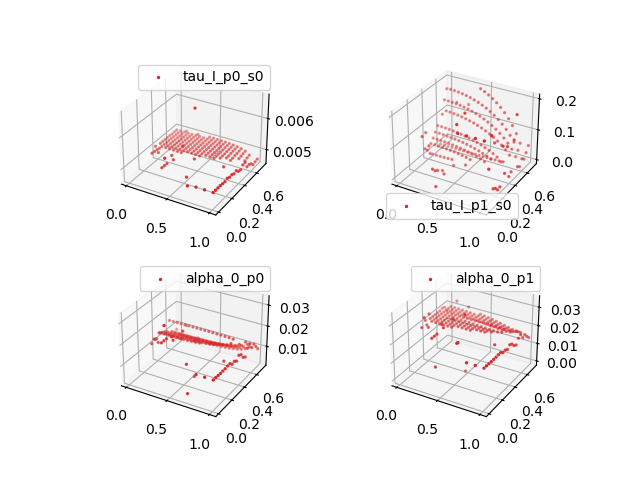

In [ ]:
X, Y = np.meshgrid(y_iter, x_iter)

# PLOT TRUE VALS ALONG WITH IT
# FIX SHITTY STARTING GUESS
# WHATS WITH SOLUTIONS FOR TAU_I - WHY DIDNT IT WORK BEFORE?

ref_vals = {
    "eta": 0.4,
    "eps": 0.6,
    "tau_I_p0_s0": 0.005,
    "tau_I_p1_s0": 0.1,
    "alpha_0_p0": 0.01,
    "alpha_0_p1": 0.02,
}

fig = plt.figure()
for i, key in enumerate(result_array):

    ax = fig.add_subplot(2, 2, i + 1, projection="3d")
    ax.scatter3D(X, Y, result_array[key], c="tab:red", s=2, label=key)
    ax.scatter3D(
        ref_vals[iter_vars[1]],
        ref_vals[iter_vars[0]],
        ref_vals[key],
        c="tab:blue",
        s=50,
        label="ref_" + key,
    )
    # ax.plot_surface(X, Y, result_array[key], color="tab:red", label=key)
    ax.legend()
    # ax.set_zlim([0, 0.1])

In [22]:
alpha_0_array

array([[[       nan,        nan, 0.01580964, 0.01542796, 0.01519426,
         0.01499938, 0.01482103, 0.0146517 , 0.01448814, 0.01432869,
         0.01417239, 0.01401868, 0.01386717, 0.01371758, 0.01356973,
         0.01342344, 0.01327861, 0.01313513, 0.01299293, 0.01285191,
         0.01271203, 0.01257323, 0.01243544, 0.01229863, 0.01216275,
         0.01202775, 0.01189359, 0.01176023, 0.01162764, 0.01149578,
         0.01136462, 0.01123411, 0.01110423, 0.01097494, 0.01084622,
         0.01071802, 0.01059032, 0.01046308, 0.01033627, 0.01020987,
         0.01008383, 0.00995814, 0.00983275, 0.00970763, 0.00958275,
         0.00945809, 0.0093336 , 0.00920925, 0.00908502, 0.00896085],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan, 

In [ ]:
from scipy.optimize import root

net.set_param("eta", 0.4)
net.set_param("eps", 0.6)

res = root(
    match_all,
    (0.01, 0.1, 0.01, 0.01),
    args=(net, bounds.keys(), root_function, bounds),
    tol=1e-12,
    method="krylov",
    options={"maxiter": 100},
)
# res = root(match_all, (0.5, 0.5, 0.02, 0.02), tol=1e-12, method="krylov")
res

 message: A solution was found at the specified tolerance.
 success: True
  status: 1
     fun: [-8.848e-02 -8.891e-02 -8.559e-04  2.872e-03]
       x: [ 4.999e-03  9.817e-02  1.258e-02  2.259e-02]
     nit: 10
  method: krylov
    nfev: 54